# ANALISI ERR vs TEMP EXTRACTED per DIVERSE LEV_RED E NUM_PAIRS

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


mother_dir = './FULLforeachPARAMETER/'
n_sets = 5
a =['0.5','0.6','0.7','0.8', '0.9'] 
b = ['20', '40', '60', '80', '100']
lev_red_list = [ [],[],[],[],[] ]

for lev_red in a:
    for num_pairs in b:

        dir_name = f'{lev_red}_{num_pairs}'

        df_tot = pd.read_csv(mother_dir + f'{dir_name}/TotalStatics.csv', header=None, na_filter=False, index_col = 0)
        tot = (df_tot.to_numpy()).T
        df_numtemp = pd.read_csv(mother_dir + f'{dir_name}/NumberTempRedu.csv', header=None, na_filter = False, index_col = 0)
        numtemp = df_numtemp.to_numpy()

        x = np.arange(1, 77+1) 

        toremove = []
        for idx, i in enumerate(tot[0]):
            if i < 0.0001:
                toremove.append(idx)

        x = np.delete(x, toremove)
        tot = np.delete(tot, toremove, axis=1)
        numtemp = np.delete(numtemp, toremove, axis=1)

        temp_dict = {}
        temp_dict['x'] = x
        temp_dict['tot'] = tot
        temp_dict['numtemp'] = numtemp
        temp_dict['num_pairs'] = num_pairs

        lev_red_list[a.index(lev_red)].append(temp_dict)       

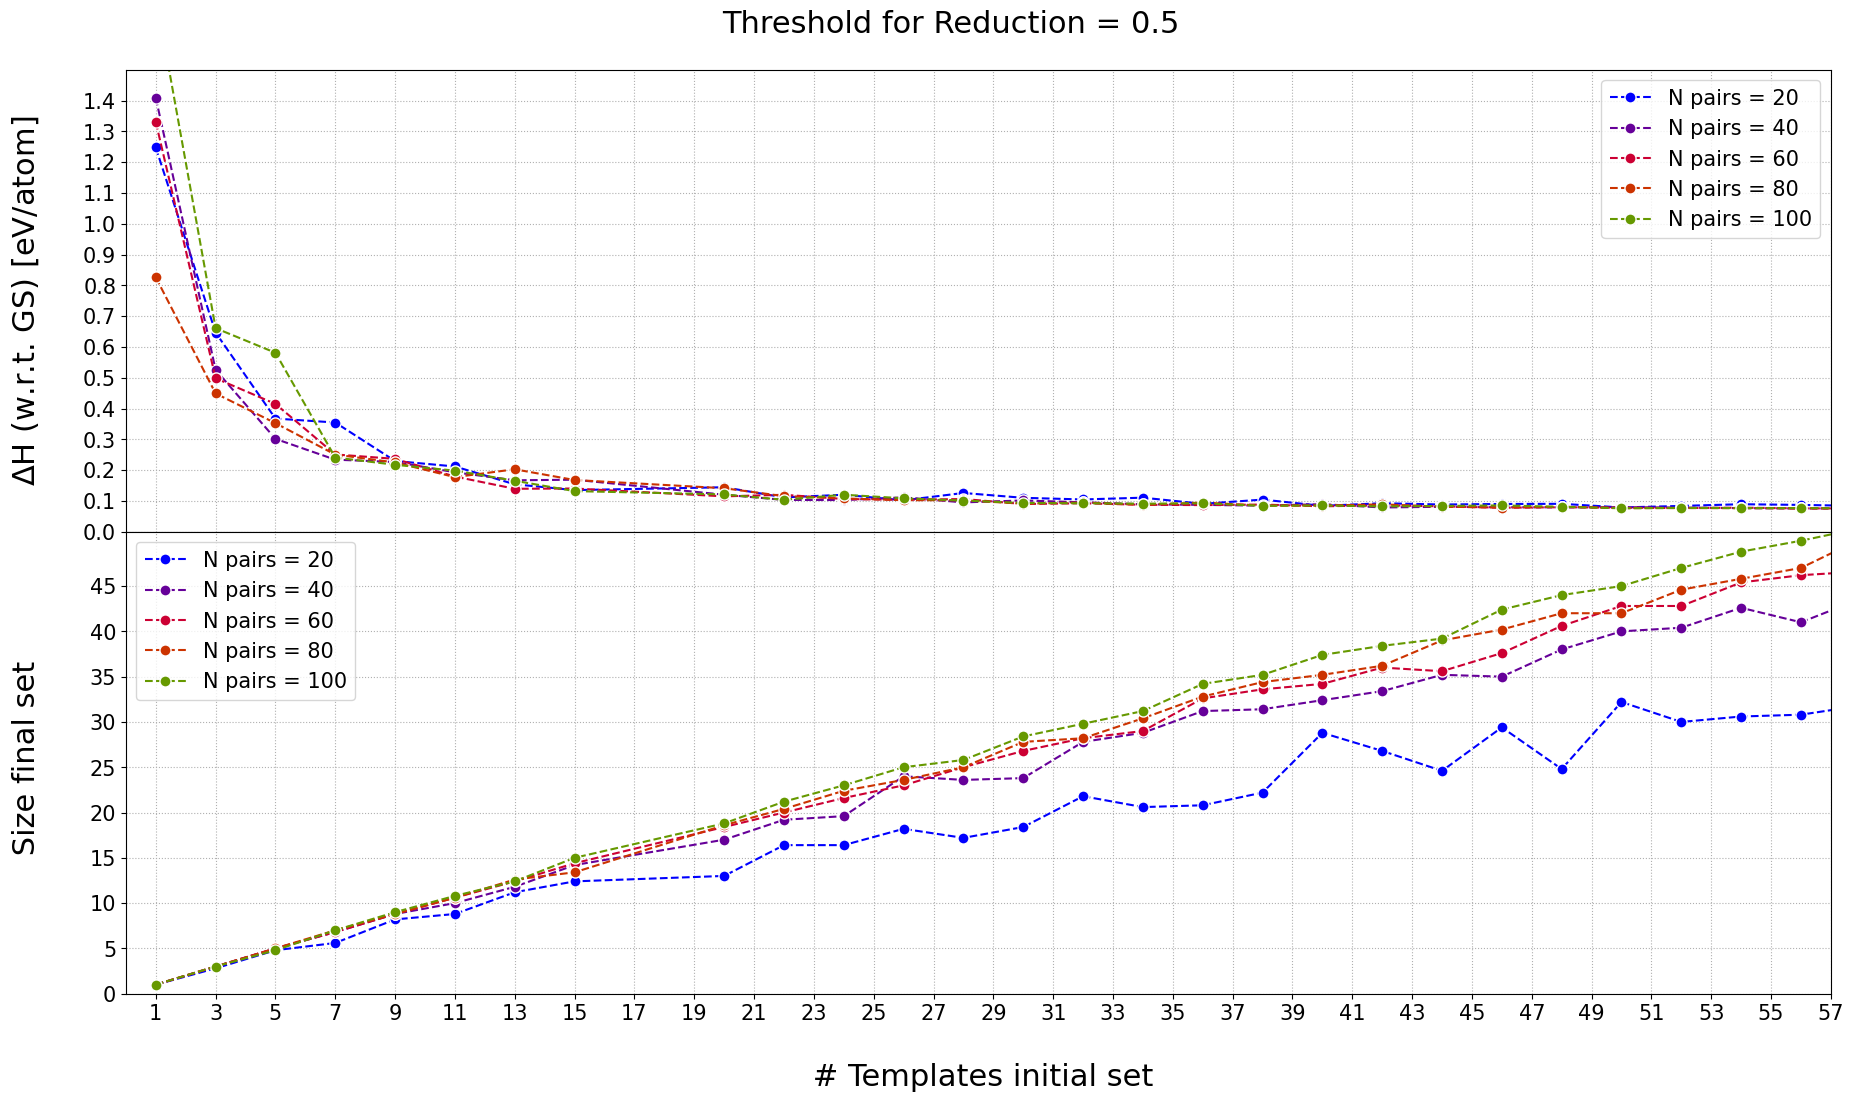

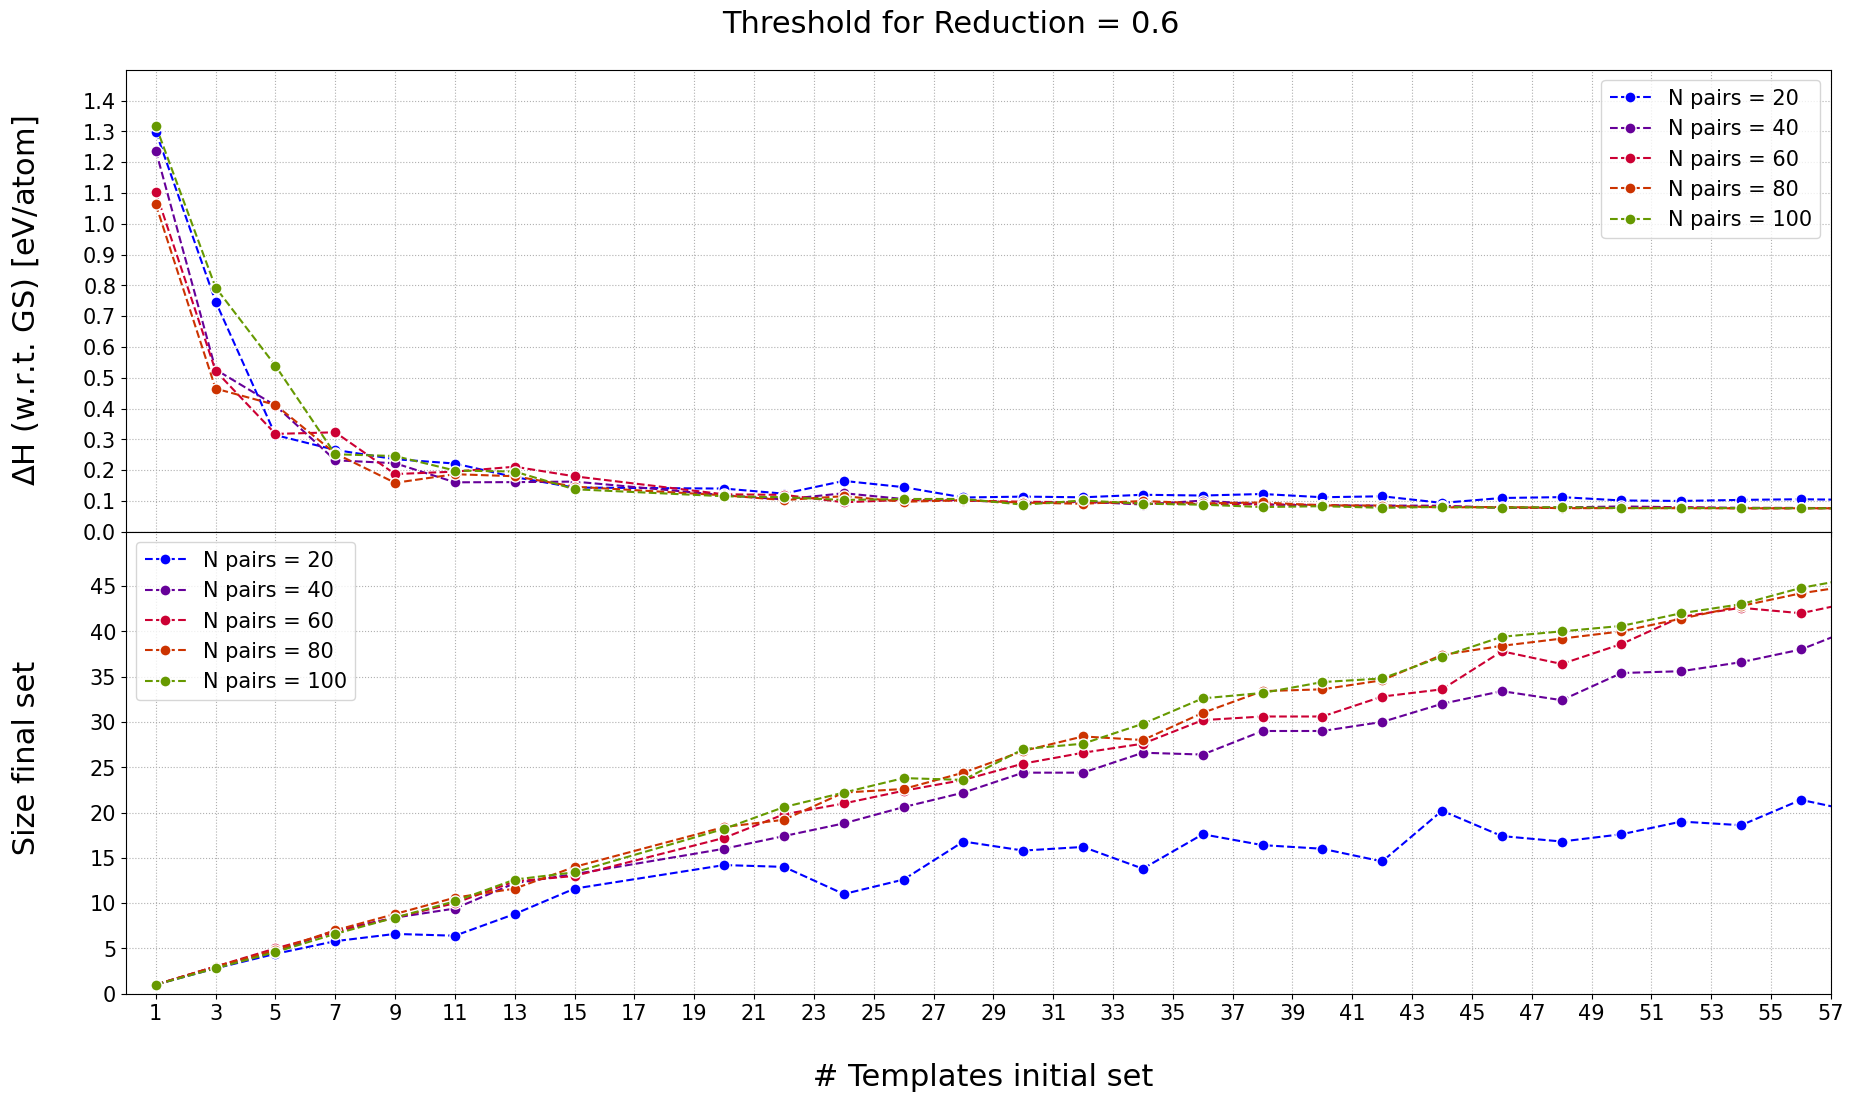

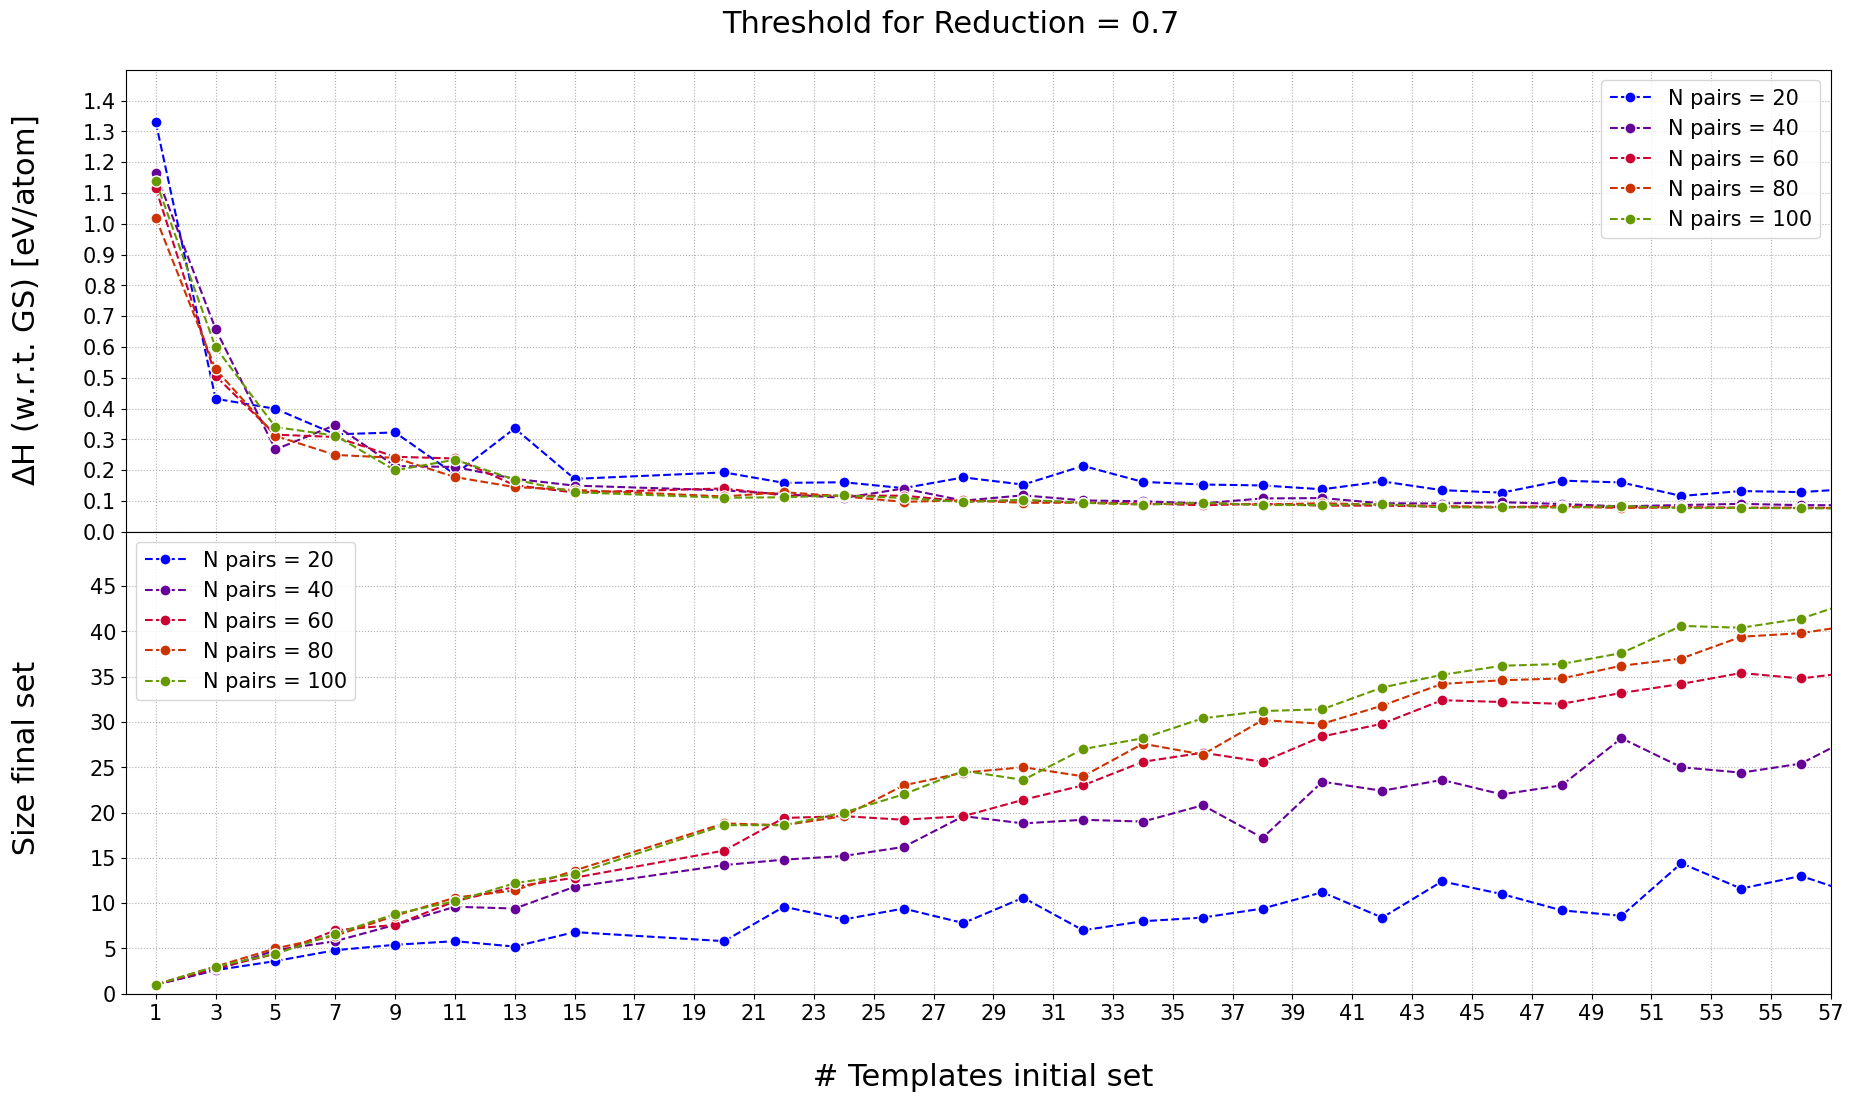

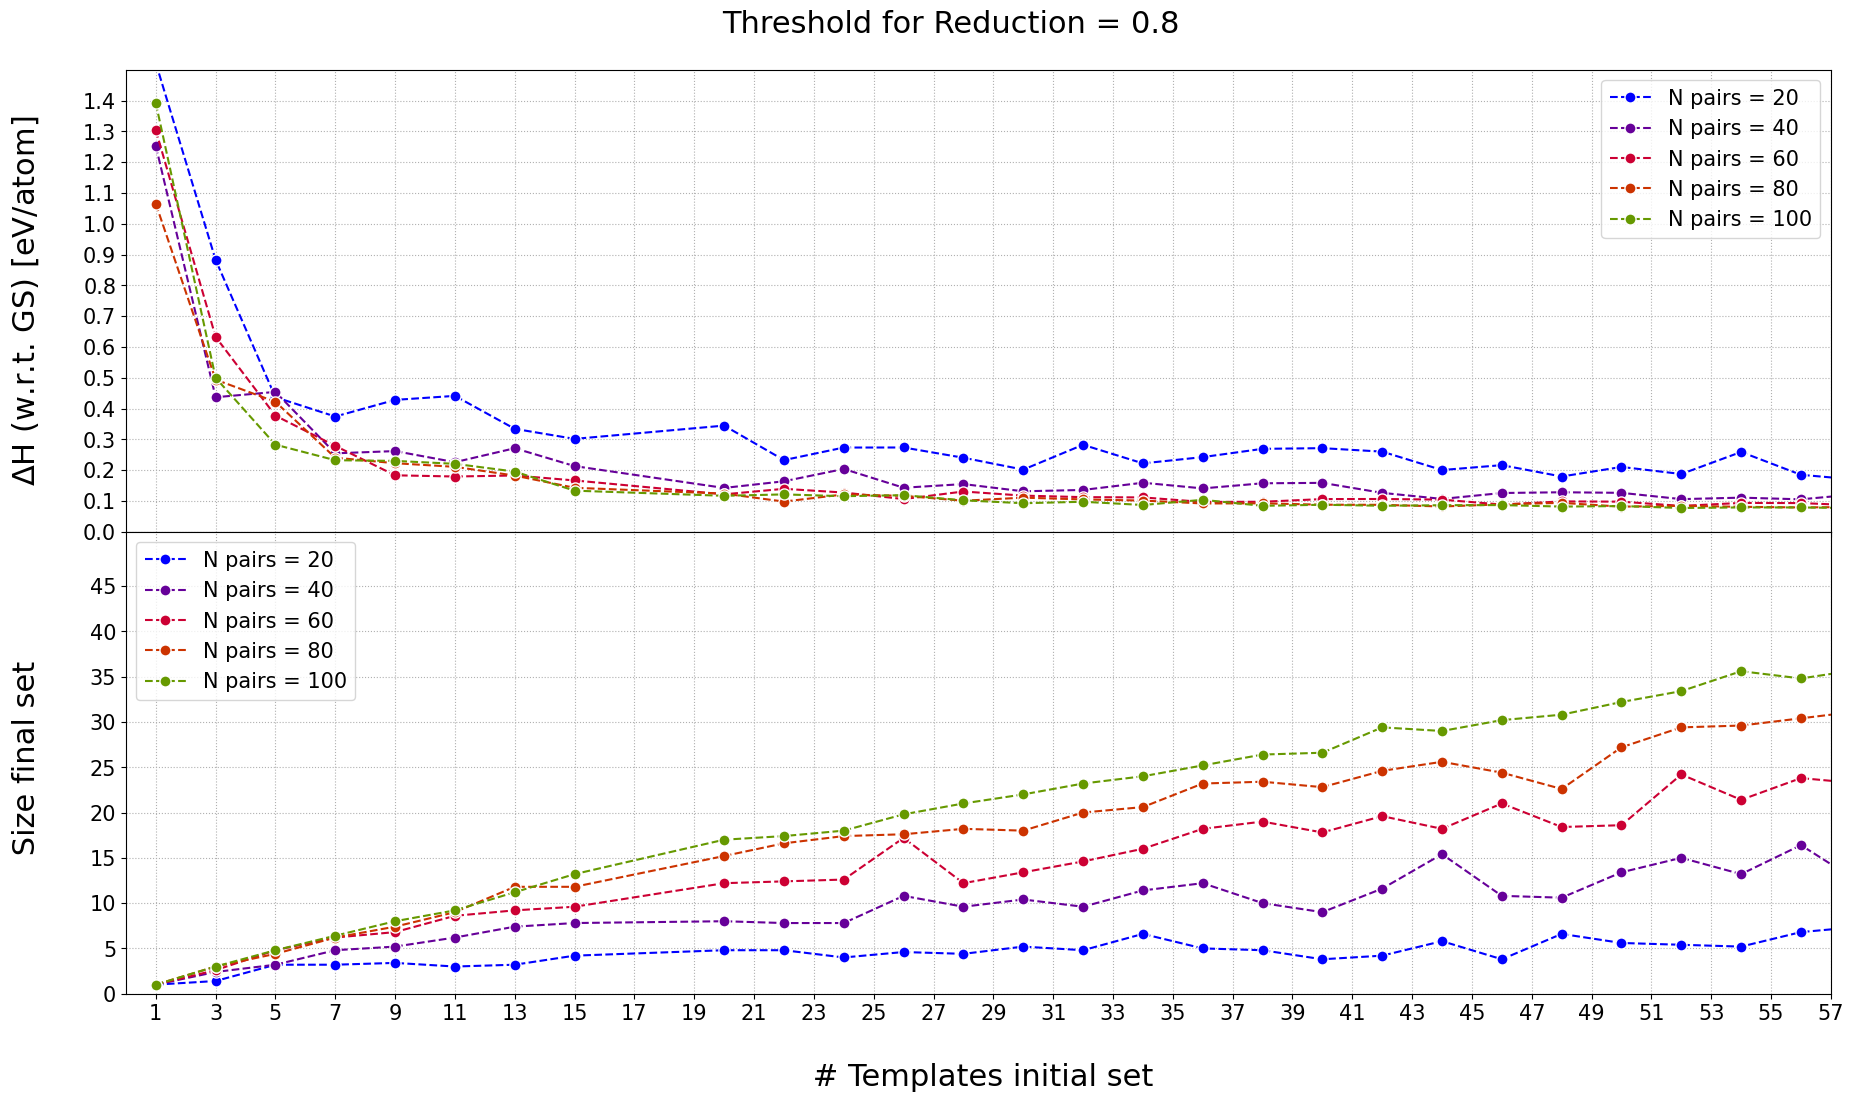

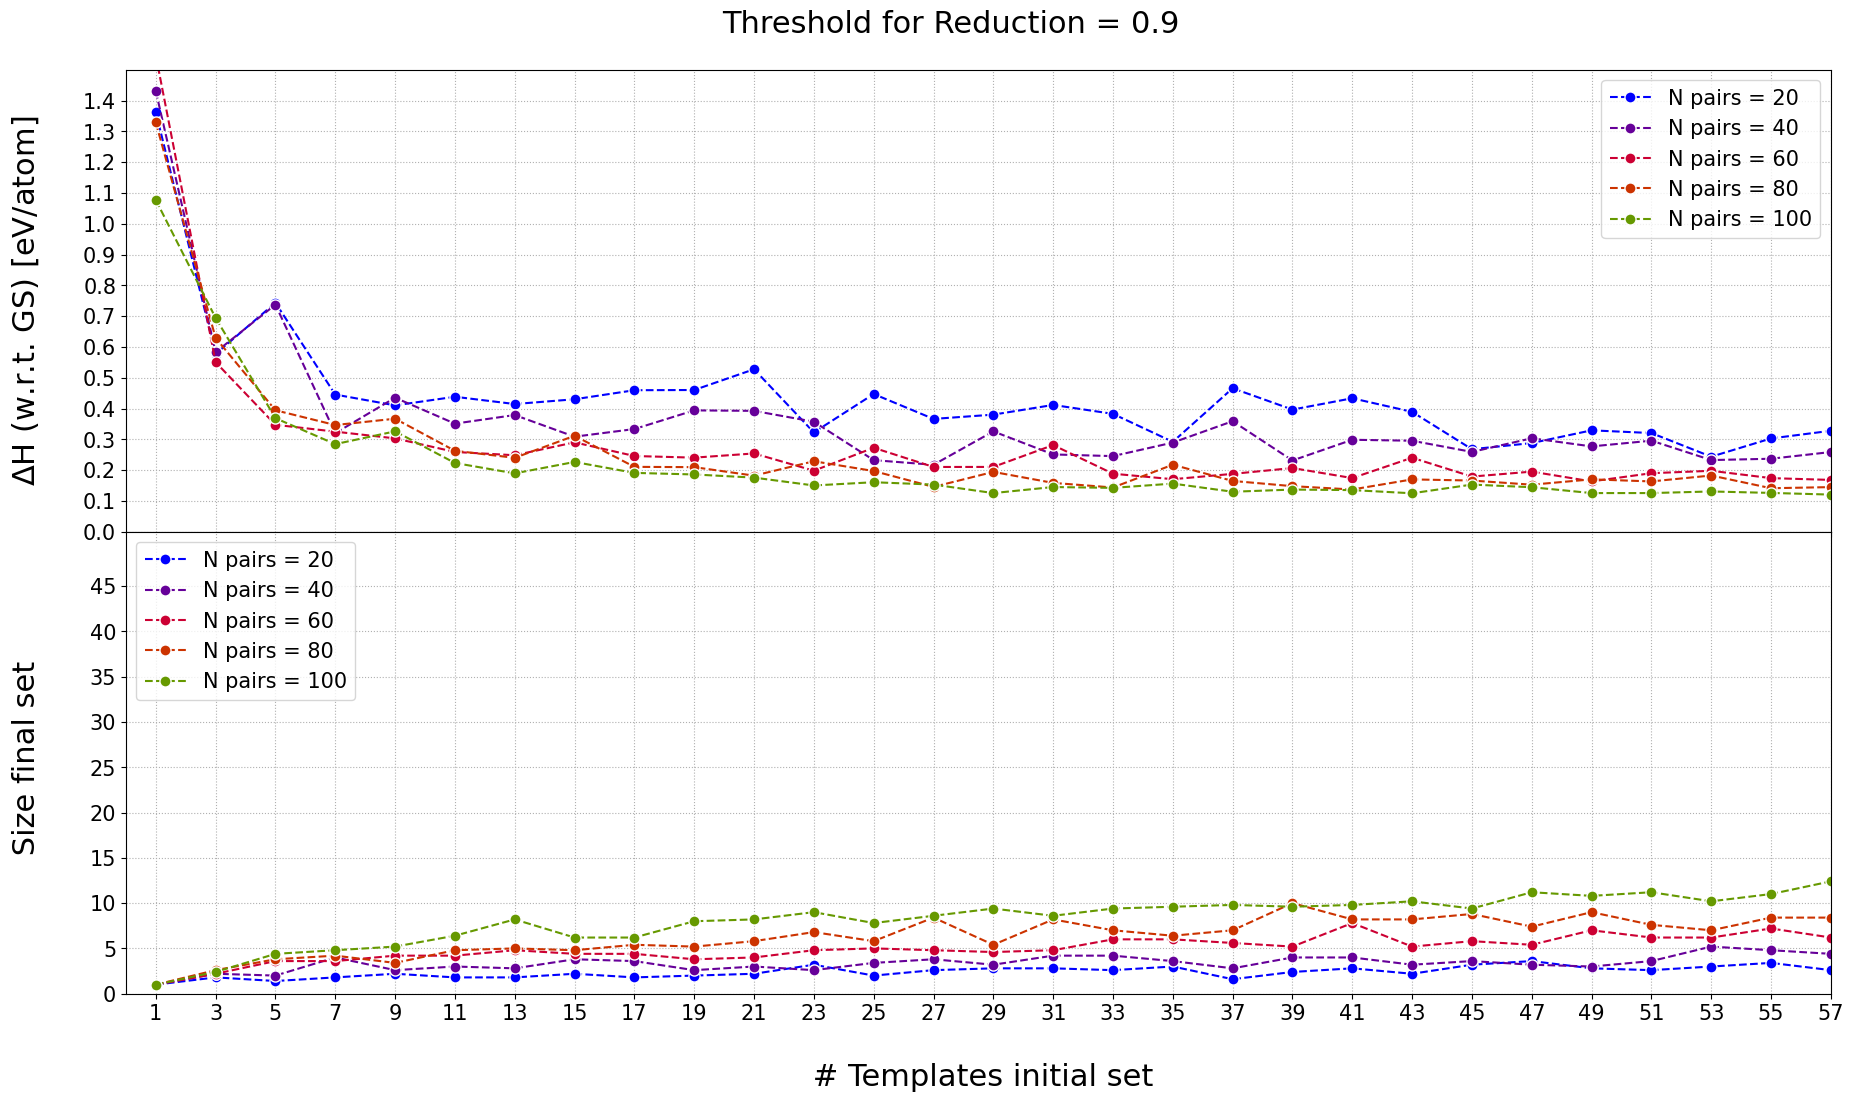

In [4]:
n_possible_couples = 105
names = ['0.5', '0.6', '0.7', '0.8', '0.9']
for idx, lev_red in enumerate(lev_red_list): 

    title = f'Threshold for Reduction = {names[idx]}'

    fig, (ax,ax1) = plt.subplots(2, 1, figsize=(22, 12), sharex=True) ## sharex=True to share the same x axis
    fig.subplots_adjust(hspace=0.0) ## space between subplots
    fig.suptitle(title, fontsize=22, y=0.93) ## title of the whole figure

    ax.grid(True, ls=':') ## grid for the first plot
    ax1.grid(True, ls=':')  ## grid for the second plot

    ax.set_ylabel(r'$\Delta$H (w.r.t. GS) [eV/atom]', fontsize=22) ## label of y axis
    ax.yaxis.set_label_coords(-0.05, 0.5) ## position of the label

    ## set the ticks for the y axis of the first plot
    step = 0.1 
    y_ticks  = np.arange(0.0, 1.5, step)
    y_ticks = np.round(y_ticks, decimals=1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=15)
    ax.set_ylim(0,1.5)

    ax1.set_ylabel(' Size final set', fontsize=22) ## label of y axis
    ax1.yaxis.set_label_coords(-0.05, 0.5) ## position of the label

    ## set the ticks for the y axis of the second plot
    step = 5
    y_ticks  = np.arange(0,50,step)
    y_ticks = np.round(y_ticks)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticks, fontsize=15)

    ax1.set_ylim(0,51)

    ## set the x axis label for both plots
    ax1.set_xlabel(' # Templates initial set', fontsize=22)
    ax1.xaxis.set_label_coords(0.5, -0.15)
    ax1.set_xticks(np.arange(1, 58, 2))
    ax1.set_xlim(0, 57)
    ax1.set_xticklabels(np.arange(1, 58, 2), fontsize=15, rotation=0)
    
    if idx == 4:
        n_possible_couples = 1
    ## plot the data
    for i in range(len(lev_red)):
        
        x = lev_red[i]['x']
        tot = lev_red[i]['tot']
        numtemp = lev_red[i]['numtemp']
        color = cm.brg(i/len(lev_red))
        ax.plot(x, tot[0]/n_possible_couples,ls = '--', color=color, marker='o', markeredgecolor='white', label = f'N pairs = {lev_red[i]["num_pairs"]}', markersize = 8 ) 
        ax1.plot(x, numtemp[0], color=color, ls='--', marker='o', markeredgecolor='white', label = f'N pairs = {lev_red[i]["num_pairs"]}', markersize = 8)

    ax.legend(fontsize=15, loc='upper right')
    ax1.legend(fontsize=15, loc='upper left')
    plt.show()
    fig.savefig(f'../LaTeX/Figure Risultati/{names[idx]}.png', bbox_inches='tight')




# ERR vs LEVRED WITH DIFFERENT NUMPAIRS

In [13]:
### IN CASE PF ERRORS

from template_csp import managetemp as mte
import os 
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']
temp_red = np.zeros((2,5,16))
en_err = np.zeros((2,5,16))

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "n_sets" : 20,
    "comp" :1,
}

for idx_lev, lev in enumerate(tqdm(range(60,91,2))):
    hyperparameters['lev_red'] = float(lev)/100

    for idx_npair, npair in enumerate(tqdm(range(20,101,20))):
        hyperparameters['n_pairs'] = npair
    
        errors = np.zeros(hyperparameters['n_sets'])
        tempafter = np.zeros(hyperparameters['n_sets'])

        for k in range(hyperparameters['n_sets']):
            hyperparameters['id_set'] = k

            template_set = mte.TemplateSet(test_elements, f'./CLUSTER METHOD/20/TemplateSet_{k}')
            reduction_set = mte.generate_one_pairset(template_set, hyperparameters, test_elements)

            errors[k] = reduction_set.total_error(hyperparameters) 
            tempafter[k] = len(reduction_set.reduced_set(hyperparameters))


        temp_red[0,idx_npair,idx_lev] = np.mean(tempafter)
        temp_red[1,idx_npair,idx_lev] = np.std(tempafter)

        # Errore totale con deviazione standard
        en_err[0,idx_npair,idx_lev] = np.mean(errors)
        en_err[1,idx_npair,idx_lev] = np.std(errors)
        
import pandas as pd
EnErrMean = pd.DataFrame(en_err[0])
EnErrStd = pd.DataFrame(en_err[1])

NTempMean = pd.DataFrame(temp_red[0])
NTempStd = pd.DataFrame(temp_red[1])

EnErrMean.to_csv('./CLUSTER METHOD/EnErrMean.csv', header=None)
EnErrStd.to_csv('./CLUSTER METHOD/EnErrStd.csv', header=None)

NTempMean.to_csv('./CLUSTER METHOD/NTempMean.csv', header=None)
NTempStd.to_csv('./CLUSTER METHOD/NTempStd.csv', header=None)

100%|██████████| 16/16 [38:03<00:00, 142.73s/it]


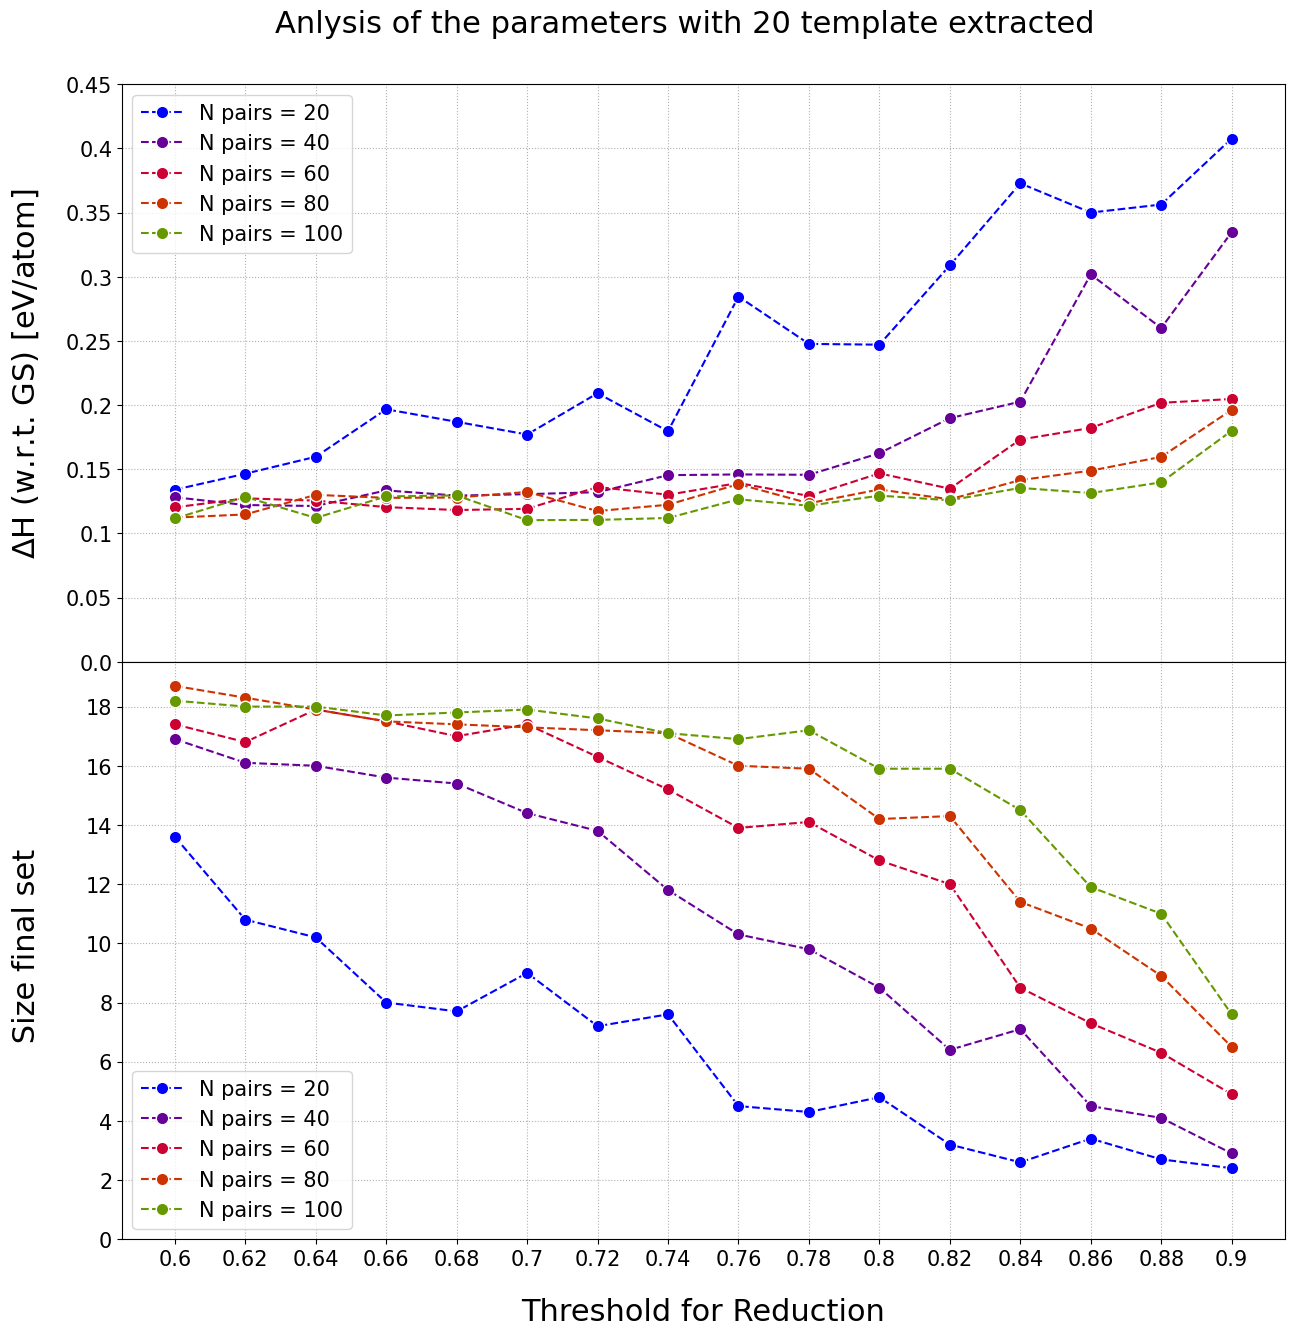

In [1]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Red_lev = np.round(np.arange(0.6, 0.91,0.02), decimals=2)
num_pairs = np.arange(20, 101, 20)
EnErrMean = pd.read_csv('PARAMETERS/EnErrMean.csv', header=None, na_filter=False, index_col=0)
EnErrMean = EnErrMean.to_numpy()
EnErrStd = pd.read_csv('PARAMETERS/EnErrStd.csv', header=None, na_filter=False, index_col=0)
EnErrStd = EnErrStd.to_numpy()
NTempMean = pd.read_csv('PARAMETERS/NTempMean.csv', header=None, na_filter=False, index_col=0)
NTempMean = NTempMean.to_numpy()
NTempStd = pd.read_csv('PARAMETERS/NTempStd.csv', header=None, na_filter=False, index_col=0)
NTempStd = NTempStd.to_numpy()

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(15, 15), sharex=True) ## sharex=True to share the same x axis
fig.subplots_adjust(hspace=0.0) ## space between subplots
fig.suptitle('Anlysis of the parameters with 20 template extracted', fontsize=22, y=0.93) ## title of the whole figure

for i in range(len(num_pairs)):
    color = cm.brg(i/len(num_pairs))

    ax.plot(Red_lev, EnErrMean[i] ,ls = '--', color=color, marker='o', markeredgecolor='white', label=f'N pairs = {num_pairs[i]}' , markersize = 9)
    ax1.plot(Red_lev, NTempMean[i], ls = '--',  color=color, marker='o', markeredgecolor='white', label=f'N pairs = {num_pairs[i]}' , markersize = 9)

ax.set_ylabel(r'$\Delta$H (w.r.t. GS) [eV/atom]', fontsize=22)
ax.yaxis.set_label_coords(-0.07, 0.5) ## position of the label
ax.set_yticks(np.round(np.arange(0.0,0.5,0.05), decimals=2))
ax.set_yticklabels(np.round(np.arange(0.0,0.5,0.05), decimals=2), fontsize=15)

ax1.set_ylabel(' Size final set', fontsize=22)
ax1.yaxis.set_label_coords(-0.07, 0.5)
ax1.set_xlabel('Threshold for Reduction', fontsize=22)
ax1.xaxis.set_label_coords(0.5, -0.1)

ax1.set_yticks(np.arange(0,20,2))
ax1.set_yticklabels(np.arange(0,20,2), fontsize=15)

ax.legend(fontsize=15, loc='upper left')
ax1.legend(fontsize=15, loc='lower left')

ax1.set_xticks(Red_lev)
ax1.set_xticklabels(Red_lev, fontsize=15)

ax.grid(True, ls=':')
ax1.grid(True, ls=':')
fig.savefig('VariousLevRed.png', bbox_inches='tight')
plt.show()


# HIST OF EXTRACTION OF SYMMETRIES